<a href="https://colab.research.google.com/github/krapukhin/DSC13/blob/main/DSC13_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Актуальные проблемы Москвы в обращениях москвичей

# Содержание
1. Обработка и анализ данных
2. Визуализации распределения по районам на карте Москвы
3. Построение Knowledge Graph
4. Выводы

# 1. Обработка и анализ данных

In [ ]:
!pip install umap
!pip install geopandas

# for pymystem proper work https://github.com/nlpub/pymystem3/issues/28
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

import pandas as pd
pd.options.display.max_rows = 100
import re
import tqdm
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

!gdown --id "1z-b5DBqR8QD_hB1vOH3i-MI8iUEIrUcR"

def preprocess_text(x):
    out = [word.rstrip() for word in (''.join(lem.lemmatize(x))).split(' ') if (word not in stop and word != '')]
    return out

--2021-05-06 15:51:51--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.245, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm908.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-05-06 15:51:51--  http://cache-mskm908.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm908.cdn.yandex.net (cache-mskm908.cdn.yandex.net)... 5.45.220.18, 2a02:6b8:0:2002::19
Connecting to cache-mskm908.cdn.yandex.net (cache-mskm908.cdn.yandex.net)|5.45.220.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.7’

mystem-3.0-linux3.1 100%[===================>] 

In [ ]:
fname= '/content/Mosru_dump_all_pages_abridged.txt'
df_raw = pd.read_csv(fname, sep="', '",header=None, names=['Category', 'Street', 'Name', 'Uprava','Date'])
df_raw.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,Category,Street,Name,Uprava,Date
66346,'Сообщение о проблеме «Незаконная установка ре...,штендер,Семенов П.В.,генеральный директор Государственного бюджетн...,28 Января 2017 в 12:31'
54093,'Сообщение о проблеме «Разрушение\\/неправильн...,Повреждена тактильная плитка на переходе через...,Насибуллин Р.М.,"директор ГБУ ""Автомобильные дороги ЮАО""",27 Апреля 2017 в 13:21'
75898,'Сообщение о проблеме «Захламление территории»...,ранее я писал про грязный снег и мусор свезенн...,Щербачев Е.Д.,глава управы Савеловского района города Москвы,30 Апреля 2018 в 14:21'


Распарсим дату и построим гистограммы распределений количества жалоб по месяцам и годам

In [ ]:
def date_extract(raw_date):
    months_order = {'Января':1, 'Февраля':2, 'Марта':3, 'Апреля':4,  
                    'Мая':5, 'Июня':6,'Июля':7, 'Августа':8, 
                    'Сентября':9, 'Октября':10,'Ноября':11, 'Декабря':12}
    pat = re.compile("\d\d\s[А-Яа-я]+\s\d\d\d\d\sв") 
    match = re.search(pat,raw_date)
    if len(raw_date)<30:
        time = raw_date[match.start():match.end()]
        time_split = time.split()
        time_day = time_split[0]
        time_month = time_split[1]
        time_year = time_split[2]
        return [raw_date[:match.start()],int(time_day),months_order[time_month],int(time_year), raw_date[match.end():]]
    else:
        return [raw_date, None,None,None, None]
    
df_raw['Date_len'] = df_raw['Date'].map(lambda x: len(x))
df_raw['Date_wrong'] = df_raw['Date'].map(lambda x: date_extract(x)[0])
df_raw['Date_day'] = df_raw['Date'].map(lambda x: date_extract(x)[1])
df_raw['Date_month'] = df_raw['Date'].map(lambda x: date_extract(x)[2])
df_raw['Date_year'] = df_raw['Date'].map(lambda x: date_extract(x)[3])
df_raw['Time'] = df_raw['Date'].map(lambda x: date_extract(x)[4])
df_raw.sort_values('Date_len', ascending=False).head(3)

,Category,Street,Name,Uprava,Date,Date_len,Date_wrong,Date_day,Date_month,Date_year,Time
74100,'Сообщение о проблеме «Захламление территории»...,"Мусор скапливается вскоре после уборки, ЗАХЛАМ...",Носенко Ю.В.,глава управы района Ново-Переделкино города М...,"07 Июня 2017 в 16:01\\nОфициальный ответ, дан ...",646,"07 Июня 2017 в 16:01\\nОфициальный ответ, дан ...",NaN,NaN,NaN,None
59730,'Сообщение о проблеме «Захламление территории»...,Произвести уборку недостаточно! Уборку надо пр...,Носенко Ю.В.,глава управы района Ново-Переделкино города М...,"17 Августа 2017 в 17:57\\nОфициальный ответ, д...",620,"17 Августа 2017 в 17:57\\nОфициальный ответ, д...",NaN,NaN,NaN,None
25055,'Сообщение о проблеме «Захламление территории»...,Свалка находится почти напротив\\nХимкинского ...,Овчинский В.А.,руководитель Государственной инспекции по кон...,31.10.2018. В ответ на мое обращение тов. Люба...,482,31.10.2018. В ответ на мое обращение тов. Люба...,NaN,NaN,NaN,None


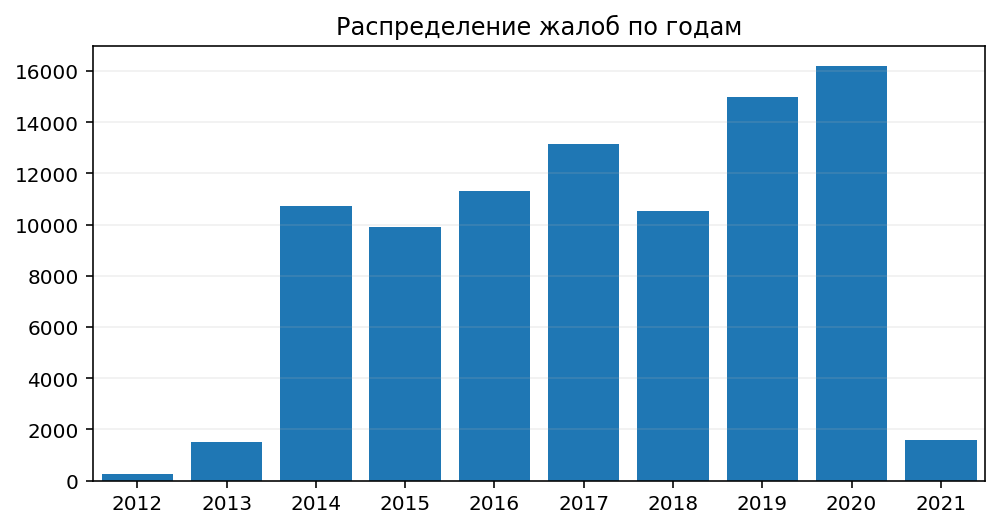

In [ ]:
year_hist = df_raw.loc[:,['Category','Date_year']].groupby('Date_year').count()
plt.figure(figsize=(8,4))
plt.bar(year_hist.index, year_hist.Category)
plt.xticks(range(2012, 2022))
plt.grid(axis='y', alpha=0.2)
plt.xlim(left=2011.5, right=2021.5)
plt.title('Распределение жалоб по годам')
plt.show()

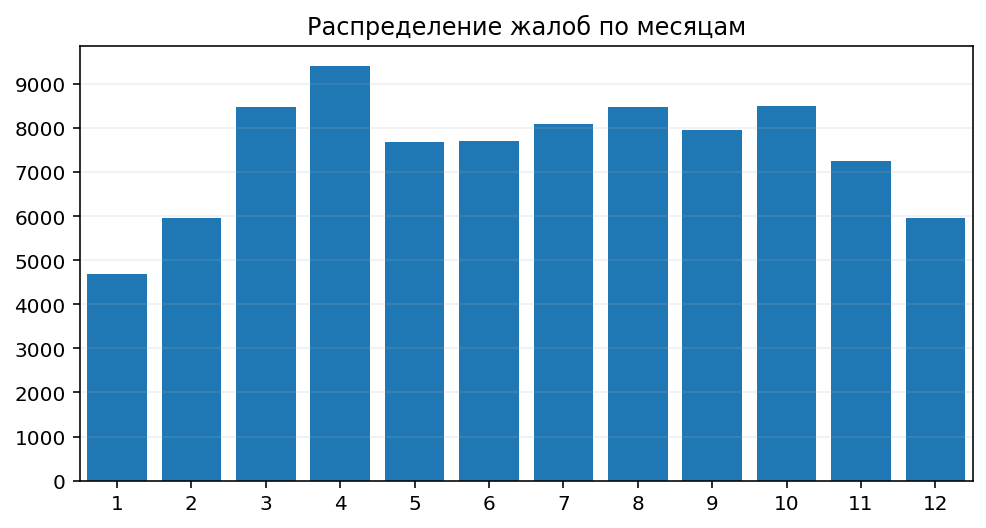

In [ ]:
month_hist = df_raw.loc[:,['Category','Date_month']].groupby('Date_month').count()
plt.figure(figsize=(8,4))
plt.bar(month_hist.index, month_hist.Category)
plt.xticks(range(1, 13))
plt.yticks(range(0,10000,1000))
plt.grid(axis='y', alpha=0.2)
plt.xlim(left=0.5,right=12.5)
plt.title('Распределение жалоб по месяцам')
plt.show()


Построим гистограмму распределения количества жалоб по фамилиям адресатов (Топ-К адресатов)

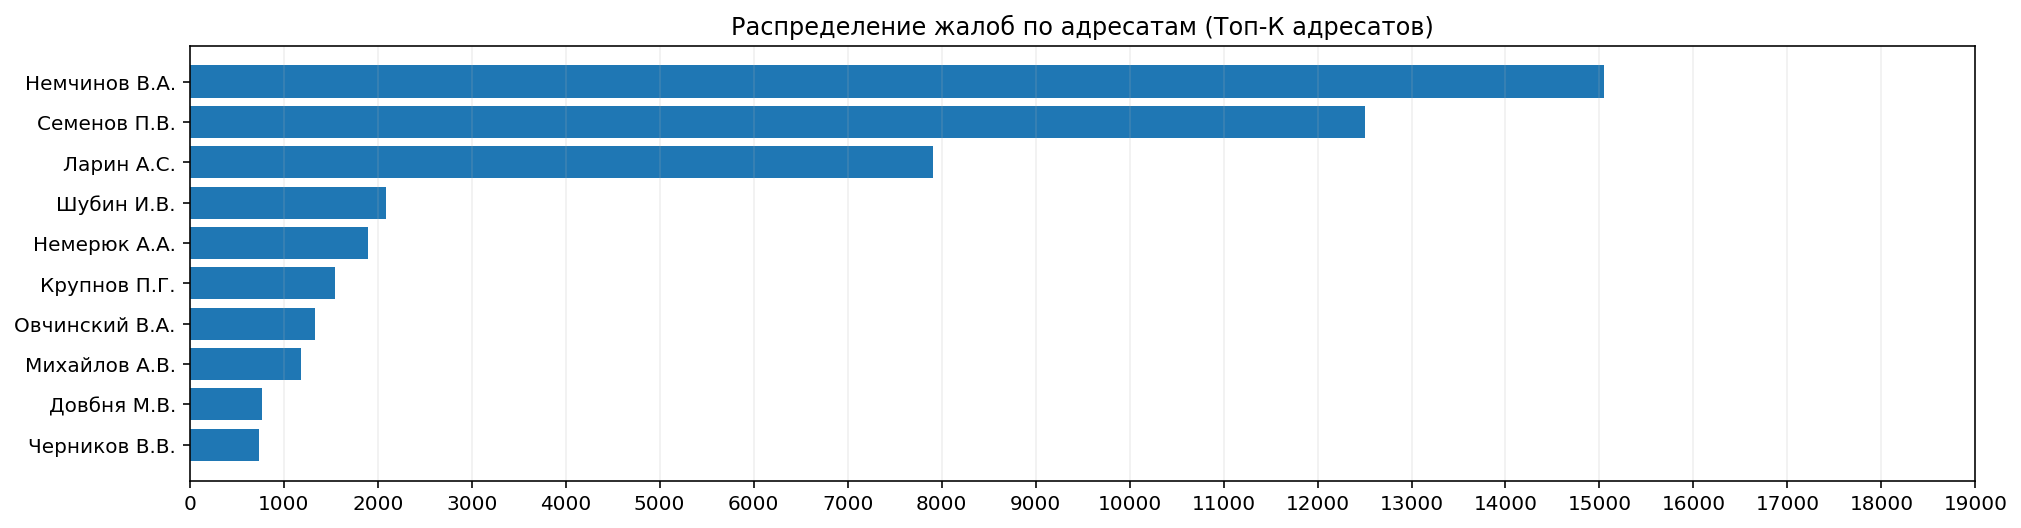

In [ ]:
k=10
name_hist = df_raw.loc[:,['Category','Name']].groupby('Name').count().sort_values('Category',ascending=False)
name_hist = name_hist.head(k).sort_values('Category')
plt.figure(figsize=(16,4))
plt.barh(name_hist.index, name_hist.Category)
plt.xticks(range(0, 20000,1000))
plt.grid(axis='x', alpha=0.2)
plt.title('Распределение жалоб по адресатам (Топ-К адресатов)')
plt.show()

Определим принадлежность жалоб к определенным районам или организациям



In [ ]:
rayony = ['Академический', 'Алексеевский', 'Алтуфьевский', 'Арбат', 'Аэропорт', 'Бабушкинский', 'Басманный', 'Беговой', 'Бескудниковский', 'Бибирево', 'Бирюлёво Восточное', 'Бирюлёво Западное', 'Богородское', 'Братеево', 'Бутово Северное', 'Бутово Южное', 'Бутырский', 'Вешняки', 'Внуково', 'Войковский', 'Восточный', 'Выхино-Жулебино', 'Гагаринский', 'Головинский', 'Гольяново', 'Даниловский', 'Дегунино Восточное', 'Дегунино Западное', 'Дмитровский', 'Донской', 'Дорогомилово', 'Замоскворечье', 'Зюзино', 'Зябликово', 'Ивановское', 'Измайлово Восточное', 'Измайлово', 'Измайлово Северное', 'Капотня', 'Коньково', 'Коптево', 'Косино-Ухтомский', 'Котловка', 'Красносельский', 'Крылатское', 'Крюково', 'Кузьминки', 'Кунцево', 'Куркино', 'Левобережный', 'Лефортово', 'Лианозово', 'Ломоносовский', 'Лосиноостровский', 'Люблино', 'Марфино', 'Марьина роща', 'Марьино', 'Матушкино', 'Медведково Северное', 'Медведково Южное', 'Метрогородок', 'Мещанский', 'Митино', 'Можайский', 'Молжаниновский', 'Москворечье-Сабурово', 'Нагатино-Садовники', 'Нагатинский затон', 'Нагорный', 'Некрасовка', 'Нижегородский', 'Ново-Переделкино', 'Новогиреево', 'Новокосино', 'Обручевский', 'Орехово-Борисово Северное', 'Орехово-Борисово Южное', 'Останкинский', 'Отрадное', 'Очаково-Матвеевское', 'Перово', 'Печатники', 'Покровское-Стрешнево', 'Преображенское', 'Пресненский', 'Проспект Вернадского', 'Раменки', 'Ростокино', 'Рязанский', 'Савёлки', 'Савёловский', 'Свиблово', 'Северный', 'Силино', 'Сокол', 'Соколиная гора', 'Сокольники', 'Солнцево', 'Старое Крюково', 'Строгино', 'Таганский', 'Тверской', 'Текстильщики', 'Тёплый Стан', 'Тимирязевский', 'Тропарёво-Никулино', 'Тушино Северное', 'Тушино Южное', 'Филёвский парк', 'Фили-Давыдково', 'Хамовники', 'Ховрино', 'Хорошёво-Мневники', 'Хорошёвский', 'Царицыно', 'Черёмушки', 'Чертаново Северное', 'Чертаново Центральное', 'Чертаново Южное', 'Щукино', 'Южнопортовый', 'Якиманка', 'Ярославский', 'Ясенево']
rayony = [re.sub('ё', 'е',x) for x in rayony]
rayony_update = []
for r in rayony:
    r_split = r.split(' ')
    if len(r_split)>1:
        if r_split[1] in ['Северное','Южное','Восточное','Западное','Центральное']:
            rayony_update += [' '.join([r_split[1],r_split[0]])]
    rayony_update += [r]

lem = Mystem()
rayony_lemmtized = [''.join(lem.lemmatize(x)).rstrip() for x in rayony_update] # иногда на этой строке ноутбук виснет, помогает перезапуск ноутбука (Среда выполнения - Перезапустить среду выполнения)
rayony_to_lemm = dict(zip(rayony_update,rayony_lemmtized))
rayony_from_lemm = dict(zip(rayony_lemmtized,rayony_update))

Построим гистограмму распределения по районам (Топ-К районов)

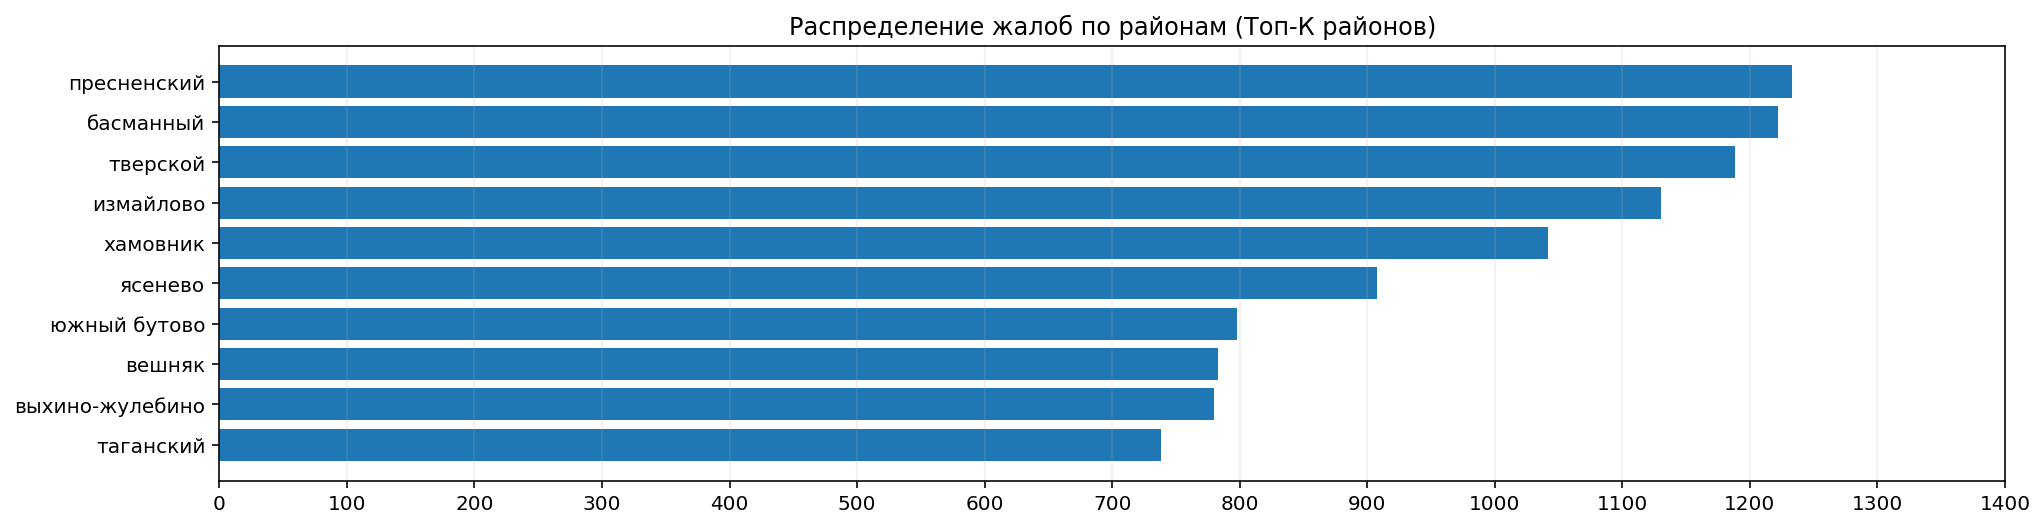

In [ ]:
def uprava_tag(string, rayony):
    tag = []
    string_lem = ' '.join([''.join(lem.lemmatize(x)).rstrip() for x in string.split(' ')]) #''.join(lem.lemmatize(string)).rstrip()
    for rayon in rayony:
        if rayon in string_lem:
            tag += [rayon]
    if len(tag) != 0:
        tag_long = max(tag, key=len)
        return tag_long
    else:
        return None

df_raw['rayon'] = df_raw['Uprava'].map(lambda x: uprava_tag(x, rayony_lemmtized))
df_taged = df_raw.loc[df_raw['rayon'].isna() == False]
rayon_hist = df_taged.loc[:,['Category','rayon']].groupby('rayon').count().sort_values('Category', ascending=False)

k = 10
rayon_hist = rayon_hist.head(k).sort_values('Category')
plt.figure(figsize=(16,4))
plt.barh(rayon_hist.index, rayon_hist.Category)
plt.xticks(range(0, 1500,100))
plt.grid(axis='x', alpha=0.2)
plt.title('Распределение жалоб по районам (Топ-К районов)')
plt.show()

Для жалоб без районов построим гистограмму распределения по организациям (Топ-К организаций)

Жалоб без районов:	 47484


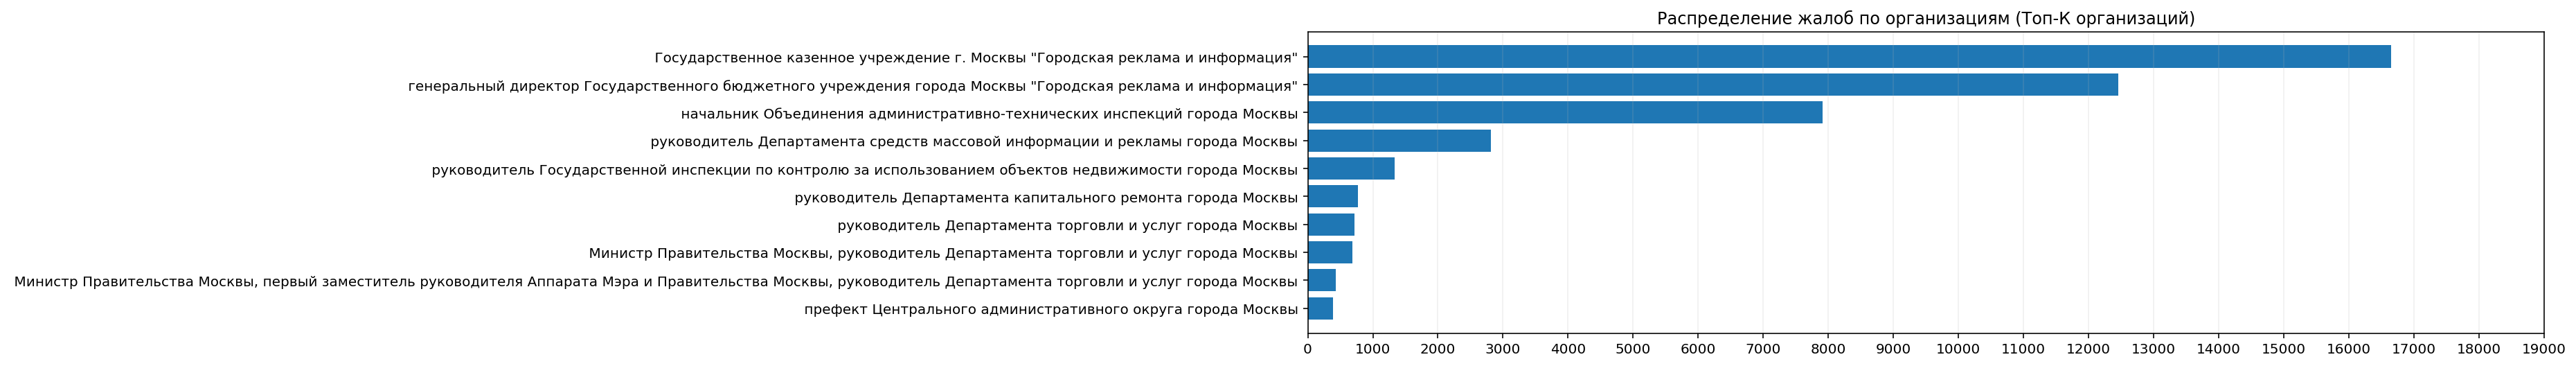

In [ ]:
print('Жалоб без районов:\t',df_raw.loc[df_raw['rayon'].isna() == True].shape[0])
df_no_tag = df_raw.loc[df_raw['rayon'].isna() == True]
nerayon_hist = df_no_tag.loc[:,['Category','Uprava']].groupby('Uprava').count().sort_values('Category', ascending=False)

k = 10
nerayon_hist = nerayon_hist.head(k).sort_values('Category')
plt.figure(figsize=(16,4))
plt.barh(nerayon_hist.index, nerayon_hist.Category)
plt.xticks(range(0, 20000,1000))
plt.grid(axis='x', alpha=0.2)
plt.title('Распределение жалоб по организациям (Топ-К организаций)')
plt.show()

Распарсим тематику и построим гистограмму распределения тематик (Топ-К тематик)

In [ ]:
df_raw['Cat0'] = df_raw['Category'].map(lambda x: x.split("«")[0])
df_raw['Cat1'] = df_raw['Category'].map(lambda x: x.split("«")[1])
df_raw['Cat2'] = df_raw['Cat1'].map(lambda x: x.split("»")[0])
df_raw['Cat3'] = df_raw['Cat1'].map(lambda x: x.split("»")[1])
df_raw.loc[:,['Category','Cat0','Cat1','Cat2','Cat3']].head(3)

,Category,Cat0,Cat1,Cat2,Cat3
0,'Сообщение о проблеме «Несоблюдение требований...,'Сообщение о проблеме,Несоблюдение требований к размещению информаци...,Несоблюдение требований к размещению информаци...,по адресу Снежная улица д.26
1,'Сообщение о проблеме «Неубранная городская те...,'Сообщение о проблеме,Неубранная городская территория» по адресу Сне...,Неубранная городская территория,по адресу Снежная улица д.24Д
2,'Сообщение о проблеме «Неубранная городская те...,'Сообщение о проблеме,Неубранная городская территория» по адресу Сне...,Неубранная городская территория,по адресу Снежная улица д.6


Общее количество тематик:  89


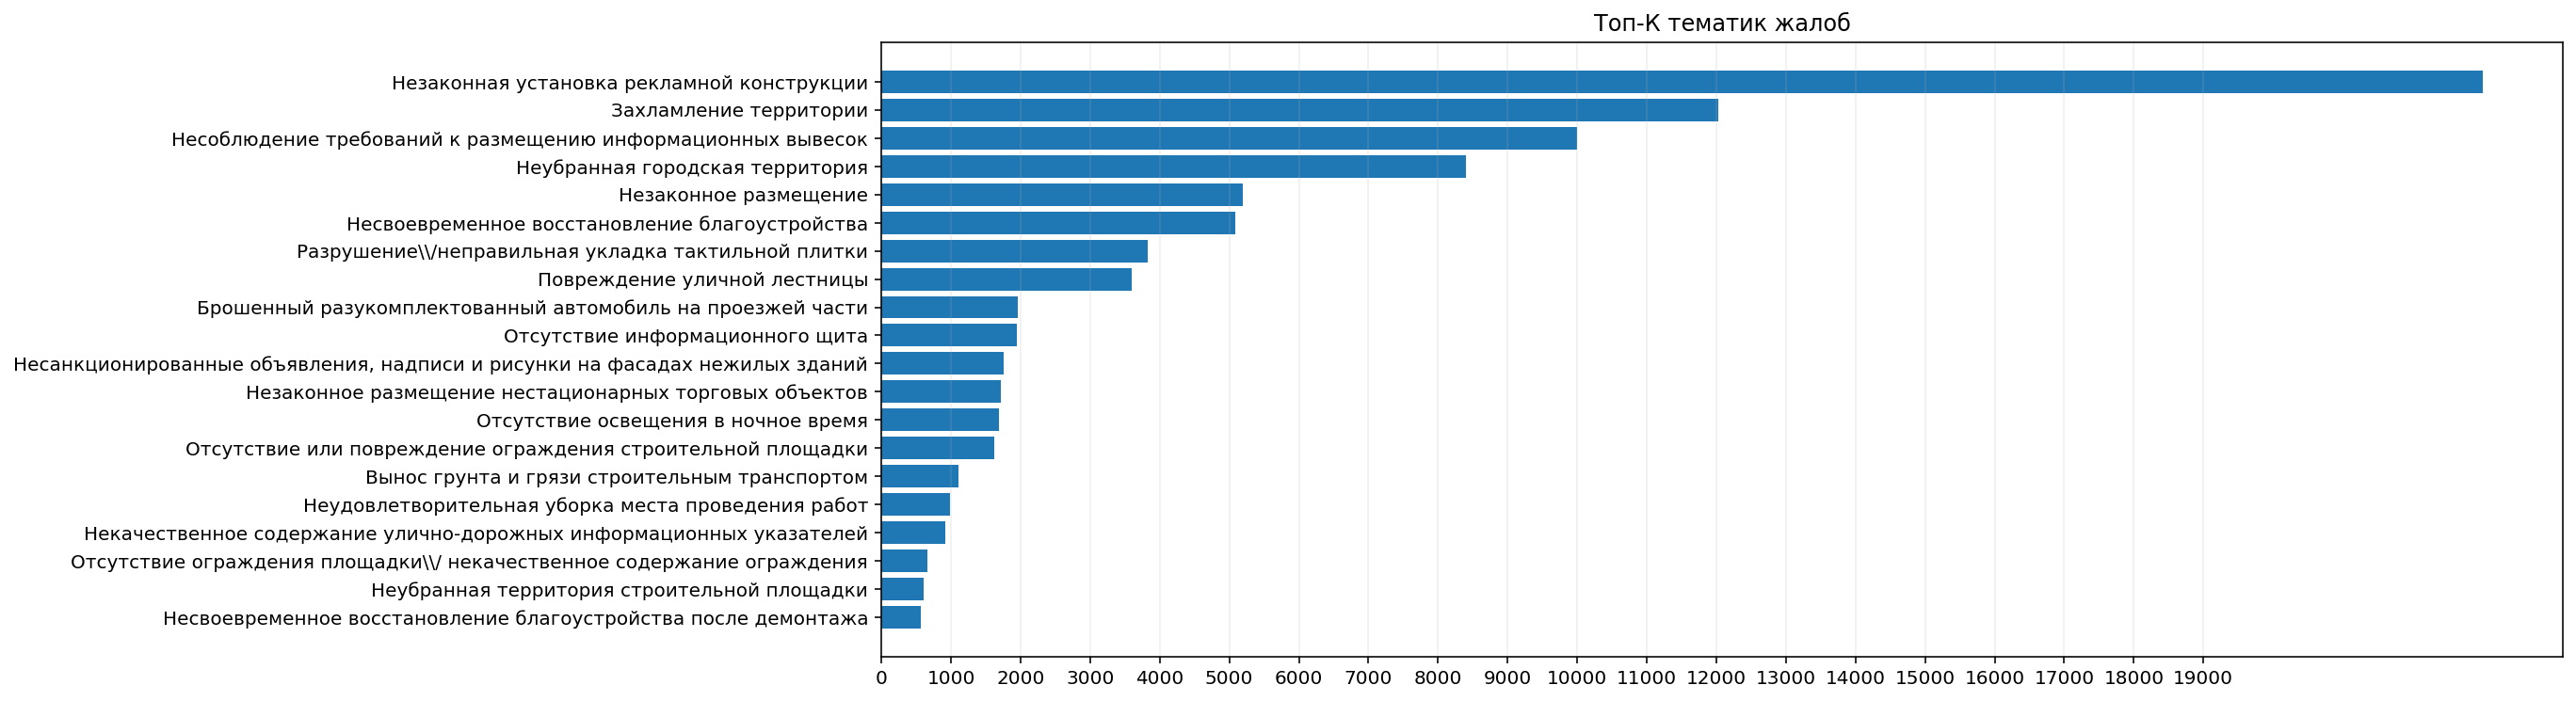

In [ ]:
category_hist = df_raw.groupby('Cat2').size().sort_values(ascending=False).reset_index()
category_hist = category_hist.rename(columns={'Cat2':'Category', 0:'Count'})
print('Общее количество тематик: ',category_hist.shape[0])

k=20
category_hist_k = category_hist.head(k).sort_values('Count')
plt.figure(figsize=(16,6))
plt.barh(category_hist_k.Category, category_hist_k.Count)
plt.xticks(range(0, 20000,1000))
plt.grid(axis='x', alpha=0.2)
plt.title('Топ-К тематик жалоб')
plt.show()

# 2. Визуализация распределения по районам на карте Москвы

Приводим вид тега района к виду геопандас

In [ ]:
df_map = df_raw.copy()
df_map = df_map.loc[:,['Category','Street','Name','Uprava','Date_wrong','Date_day','Date_month','Date_year','rayon']]
df_map = df_map.loc[df_map['rayon'].isna() == False]
df_map.head(3)


,Category,Street,Name,Uprava,Date_wrong,Date_day,Date_month,Date_year,rayon
1,'Сообщение о проблеме «Неубранная городская те...,По адресу Снежная д24 расположена музыкальная ...,Кучма А.А.,глава управы района Свиблово города Москвы,,5.0,5.0,2020.0,свиблово
3,'Сообщение о проблеме «Неубранная городская те...,Очистите опору освещения. Приведите в надлежащ...,Кучма А.А.,глава управы района Свиблово города Москвы,,16.0,1.0,2020.0,свиблово
4,'Сообщение о проблеме «Захламление территории»...,Более двух недель лежит куча грунта в перемешк...,Сержантов С.А.,и.о. главы управы района Свиблово города Москвы,,24.0,8.0,2019.0,свиблово


In [ ]:
rayony_from_lemm_new = rayony_from_lemm.copy()
rayony_from_lemm_new['бирюлево западный'] = 'Бирюлёво Западное'
rayony_from_lemm_new['бирюлево восточный'] = 'Бирюлёво Восточное'
rayony_from_lemm_new['марьин роща'] = 'Марьина Роща'
rayony_from_lemm_new['нагатинский затон'] = 'Нагатинский Затон'
rayony_from_lemm_new['савелка'] = 'Савёлки'
rayony_from_lemm_new['савеловский'] = 'Савёловский'
rayony_from_lemm_new['соколиный гора'] = 'Соколиная Гора'
rayony_from_lemm_new['теплый стан'] = 'Тёплый Стан'
rayony_from_lemm_new['тропарево-никулино'] = 'Тропарёво-Никулино'
rayony_from_lemm_new['филевский парк'] = 'Филёвский Парк'
rayony_from_lemm_new['хорошево-мневники'] = 'Хорошёво-Мнёвники'
rayony_from_lemm_new['хорошевский'] = 'Хорошёвский'
rayony_from_lemm_new['черемушки'] = 'Черёмушки'
rayony_to_lemm_new = {y:x for x,y in rayony_from_lemm_new.items()}

In [ ]:
df_map['NAME'] = df_map['rayon'].map(lambda x: rayony_from_lemm_new[x])
df_map_group = df_map.loc[:,['NAME','rayon']].groupby('NAME').count()
df_map_group = df_map_group.reset_index().rename(columns={'rayon':'rayon_counter'})
df_map_group.head(3)

,NAME,rayon_counter
0,Академический,268
1,Алексеевский,202
2,Алтуфьевский,91


In [ ]:
!gdown --id "1jQ-dhgZXdEEoPggomDL7B3E2CmA7ILmi"
import geopandas as gpd
mo_gdf = gpd.read_file('/content/mo-shape.zip') # Полигоны для построения районов http://gis-lab.info/data/mos-adm/mo-shape.zip
geo_rayon = pd.merge(mo_gdf,df_map_group, left_on = 'NAME', right_on='NAME', how='inner')
geo_rayon.loc[geo_rayon['rayon_counter'].isna()==True,'rayon_counter'] = 0
geo_rayon.sort_values('rayon_counter')


Downloading...
From: https://drive.google.com/uc?id=1jQ-dhgZXdEEoPggomDL7B3E2CmA7ILmi
To: /content/mo-shape.zip
100% 428k/428k [00:00<00:00, 56.2MB/s]


,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry,rayon_counter
4,Силино,45272572,45332000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((37.13160 56.01645, 37.13266 56.01678...",15
1,Матушкино,45272562,45331000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((37.17853 56.00795, 37.18083 56.00825...",20
8,Старое Крюково,45272576,45927000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((37.17327 55.98044, 37.17597 55.98174...",34
3,Савёлки,45272568,45377000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((37.20946 56.00083, 37.20975 56.00088...",41
42,Беговой,45277556,45334000,Северный,45277000,САО,Муниципальный округ,"POLYGON ((37.54084 55.78496, 37.54188 55.78541...",45
...,...,...,...,...,...,...,...,...,...
52,Хамовники,45286590,45383000,Центральный,45286000,ЦАО,Муниципальный округ,"POLYGON ((37.54108 55.72013, 37.54118 55.72206...",1042
111,Измайлово,45263570,45307000,Восточный,45263000,ВАО,Муниципальный округ,"POLYGON ((37.74300 55.78780, 37.74301 55.78816...",1130
64,Тверской,45286585,45382000,Центральный,45286000,ЦАО,Муниципальный округ,"POLYGON ((37.57523 55.77552, 37.57599 55.77561...",1188
83,Басманный,45286555,45375000,Центральный,45286000,ЦАО,Муниципальный округ,"POLYGON ((37.62790 55.75954, 37.62807 55.75961...",1222


In [ ]:
import folium
import json
def party_color(feature):
    if (feature['properties']['rayon_counter']*100/1233)>0:
        color = '#a8e6cf'
    if (feature['properties']['rayon_counter']*100/1233)>20:
        color = '#dcedc1'
    if (feature['properties']['rayon_counter']*100/1233)>40:
        color = '#ffd3b6'
    if (feature['properties']['rayon_counter']*100/1233)>60:
        color = '#ffaaa5'
    if (feature['properties']['rayon_counter']*100/1233)>80:
        color = '#ff8b94'
    return {"fillColor":color, "fillOpacity":0.6,"opacity":0}
    
def popup_html(feature):
    html = '<h5> Район {}</h5>'.format(feature['properties']['NAME'])
    html += '<br><b>Количество жалоб</b>: {}'.format(feature['properties']['rayon_counter'])
    return html

m = folium.Map(location=[55.764414, 37.647859], zoom_start=11)

for mo in json.loads(geo_rayon.to_json())['features']:
    gj = folium.GeoJson(data=mo, style_function = party_color, control=False, highlight_function=lambda x:{"fillOpacity":0.8, "opacity":0.8}, smooth_factor=0)
    folium.Popup(popup_html(mo)).add_to(gj)
    gj.add_to(m)


Интерактивная карта (можно приближать и кликать на интересующий район)

In [ ]:
m

# 3. Построение Knowledge graph 
Для построения Графа Знаний используется библиотека stanza. Она позволяет разобрать текст на корень и зависимые слова. Так как тексты обращений содержат главным образом жалобы, решено отказаться от триплетов subject-verb-object. Таким образом задача сводится к поиску пар "родительское_слово+дочернее_слово"



In [ ]:
!pip install stanza
!pip install treelib
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
from treelib import Node, Tree
from datetime import datetime
import stanza
stanza.download('ru')       
nlp = stanza.Pipeline(lang='ru') 

2021-05-06 15:53:03 INFO: Downloading default packages for language: ru (Russian)...
2021-05-06 15:53:04 INFO: File exists: /root/stanza_resources/ru/default.zip.
2021-05-06 15:53:11 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-05-06 15:53:11 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2021-05-06 15:53:11 INFO: Use device: cpu
2021-05-06 15:53:11 INFO: Loading: tokenize
2021-05-06 15:53:11 INFO: Loading: pos
2021-05-06 15:53:11 INFO: Loading: lemma
2021-05-06 15:53:11 INFO: Loading: depparse
2021-05-06 15:53:12 INFO: Loading: ner
2021-05-06 15:53:14 INFO: Done loading processors!


In [ ]:
df_full = df_raw.loc[:,['Category', 'Street', 'Name', 'Uprava', 'Date_wrong', 'Date_day','Date_month', 'Date_year', 'rayon']]

def remove_stop_words(raw_text):
    out = []
    stop_list = ['добрый', 'день', 'здравствуйте', 'спасибо','ул','примите','меры','стр', 'прошу', 'устранить','пп', 'по','адресу','адр','москва']
    for el in re.split('[.!?]', raw_text):
        word_list = [x for x in re.split('[^а-яА-ЯёЁ]+',el) if x.lower() not in stop_list and len(x.lower())>1]
        if len(word_list)> 1:
            string = ' '.join(word_list)
            if string:
                out += [string]
    return '. '.join(out)


def triples_maker(dict_2):
    dict_ = dict_2.copy()
    added = set()
    parent_series = pd.Series(dtype='object')
    child_series = pd.Series(dtype='object')
    while dict_:
        for key, value in dict_.items():
            if value['parent'] in added:
                parent_series = parent_series.append(pd.Series([key]), ignore_index=True)
                child_series = child_series.append(pd.Series([value['parent']]), ignore_index=True)
                added.add(key)
                dict_.pop(key)
                break
            elif value['parent'] is None:
                added.add(key)
                dict_.pop(key)
                break

    return pd.DataFrame({'parent':parent_series,'child':child_series})


def tree_show(dict_2):
    added = set()
    tree = Tree()
    dict_ = dict_2.copy()
    while dict_:
        for key, value in dict_.items():
            if value['parent'] in added:
                tree.create_node(key, key, parent=value['parent'])
                added.add(key)
                dict_.pop(key)
                break
            elif value['parent'] is None:
                tree.create_node(key, key)
                added.add(key)
                dict_.pop(key)
                break

    tree.show()


def get_knowledge(text):
    knowledge_list = []
    for el in re.split('[.!?]', text):
        el = re.sub(r'\\n','', el)
        el = ' '.join(re.findall(r'[а-яА-ЯёЁ]{2,}', el))
        doc = nlp(el)
        if doc.sentences:
            for token in doc.sentences[0].tokens:
                if token.to_dict()[0]['deprel'] =='punct':
                    continue
                word = token.to_dict()[0]['text']
                head_id = token.to_dict()[0]['head']
                if head_id > 0:
                    knowledge_list += [(doc.sentences[0].words[head_id-1].lemma,doc.sentences[0].words[head_id-1].upos, token.to_dict()[0]['lemma'],token.to_dict()[0]['upos'])]

    return knowledge_list


def plot_graph(graph):
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(graph,k=0.7)
    nx.draw(graph, with_labels=True, node_color='skyblue',node_size=800, edge_cmap=plt.cm.Blues, pos=pos)
    plt.show()


def filter_df(res_df, remove_upos): 
    kg_df = res_df.reset_index().drop_duplicates()
    drop_df_1 = kg_df.loc[kg_df['parent_upos'].isin(remove_upos)]
    drop_df_2 = kg_df.loc[kg_df['child_upos'].isin(remove_upos)]
    drop_df = pd.concat([drop_df_1,drop_df_2]).drop_duplicates()
    filtered_df_1 = kg_df.loc[~kg_df['parent_upos'].isin(remove_upos)]
    filtered_df_2 = kg_df.loc[~kg_df['child_upos'].isin(remove_upos)]
    filtered_df = filtered_df_2.loc[filtered_df_2.index.isin(filtered_df_1.index)]

    assert res_df.equals(pd.concat([drop_df,filtered_df]).drop('index', axis=1).sort_index())

    return drop_df.drop('index', axis=1), filtered_df.drop('index', axis=1)

## Основной принцип работы

Библиотека stanza позволяет разобрать текст на корень+зависимые_слова, найти леммы, проставить POS-тэги, найти отношения и именованные сущности. Разберем одно случайное предложение. 

In [ ]:
tested = df_full.sample(1)
test_string = tested.iloc[0,:].Street
print(test_string)
list_of_trees = []
for el in re.split('[.!?]', test_string):
    el = re.sub(r'\\n','', el)
    tree_dict = {}
    el = ' '.join(re.findall(r'[а-яА-ЯёЁ]{2,}', el))
    doc = nlp(el)
    print(*[f'id: {word.id}\tword: {word.text}\tlemma:{word.lemma}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}\tupos: {word.upos}' for sent in doc.sentences for word in sent.words], sep='\n')
    if doc.sentences:
        for token in doc.sentences[0].tokens:
            if token.to_dict()[0]['deprel'] =='punct':
                continue
            word = token.to_dict()[0]['text']
            head_id = token.to_dict()[0]['head']
            if head_id > 0:
                tree_dict[token.to_dict()[0]['lemma']] = {'parent':doc.sentences[0].words[head_id-1].lemma}
            else:
                tree_dict[token.to_dict()[0]['lemma']] = {'parent':None}
    list_of_trees += [tree_dict]

Прошу проверить законность данного объекта.
id: 1	word: Прошу	lemma:просить	head id: 0	head: root	deprel: root	upos: VERB
id: 2	word: проверить	lemma:проверить	head id: 1	head: Прошу	deprel: xcomp	upos: VERB
id: 3	word: законность	lemma:законность	head id: 2	head: проверить	deprel: obj	upos: NOUN
id: 4	word: данного	lemma:данный	head id: 5	head: объекта	deprel: amod	upos: ADJ
id: 5	word: объекта	lemma:объект	head id: 3	head: законность	deprel: nmod	upos: NOUN



В первом столбце указан идентификатор слова внутри предложения. Во втором его лемма. В третьем и четвертом - родительское слово (если его нет, то ставится "root"). В пятом столбце отношения. В шестом проставляется POS-тег.   
Построим дерево зависимостей для полученного текста

In [ ]:
print(test_string)
res_df = pd.DataFrame()
for tree in list_of_trees:
    res_df = res_df.append(triples_maker(tree), ignore_index=True)
    tree_show(tree)

Прошу проверить законность данного объекта.
просить
└── проверить
    └── законность
        └── объект
            └── данный

Tree is empty



Представим зависимости слов в виде датафрейма

In [ ]:
knowledge_list = get_knowledge(test_string)
print(test_string)
print(knowledge_list)
res_df = pd.DataFrame(knowledge_list, columns = ['parent','parent_upos','child', 'child_upos'])#.sort_values('child')
print(res_df)

Прошу проверить законность данного объекта.
[('просить', 'VERB', 'проверить', 'VERB'), ('проверить', 'VERB', 'законность', 'NOUN'), ('объект', 'NOUN', 'данный', 'ADJ'), ('законность', 'NOUN', 'объект', 'NOUN')]
       parent parent_upos       child child_upos
0     просить        VERB   проверить       VERB
1   проверить        VERB  законность       NOUN
2      объект        NOUN      данный        ADJ
3  законность        NOUN      объект       NOUN


Построим дерево зависимостей в виде графа

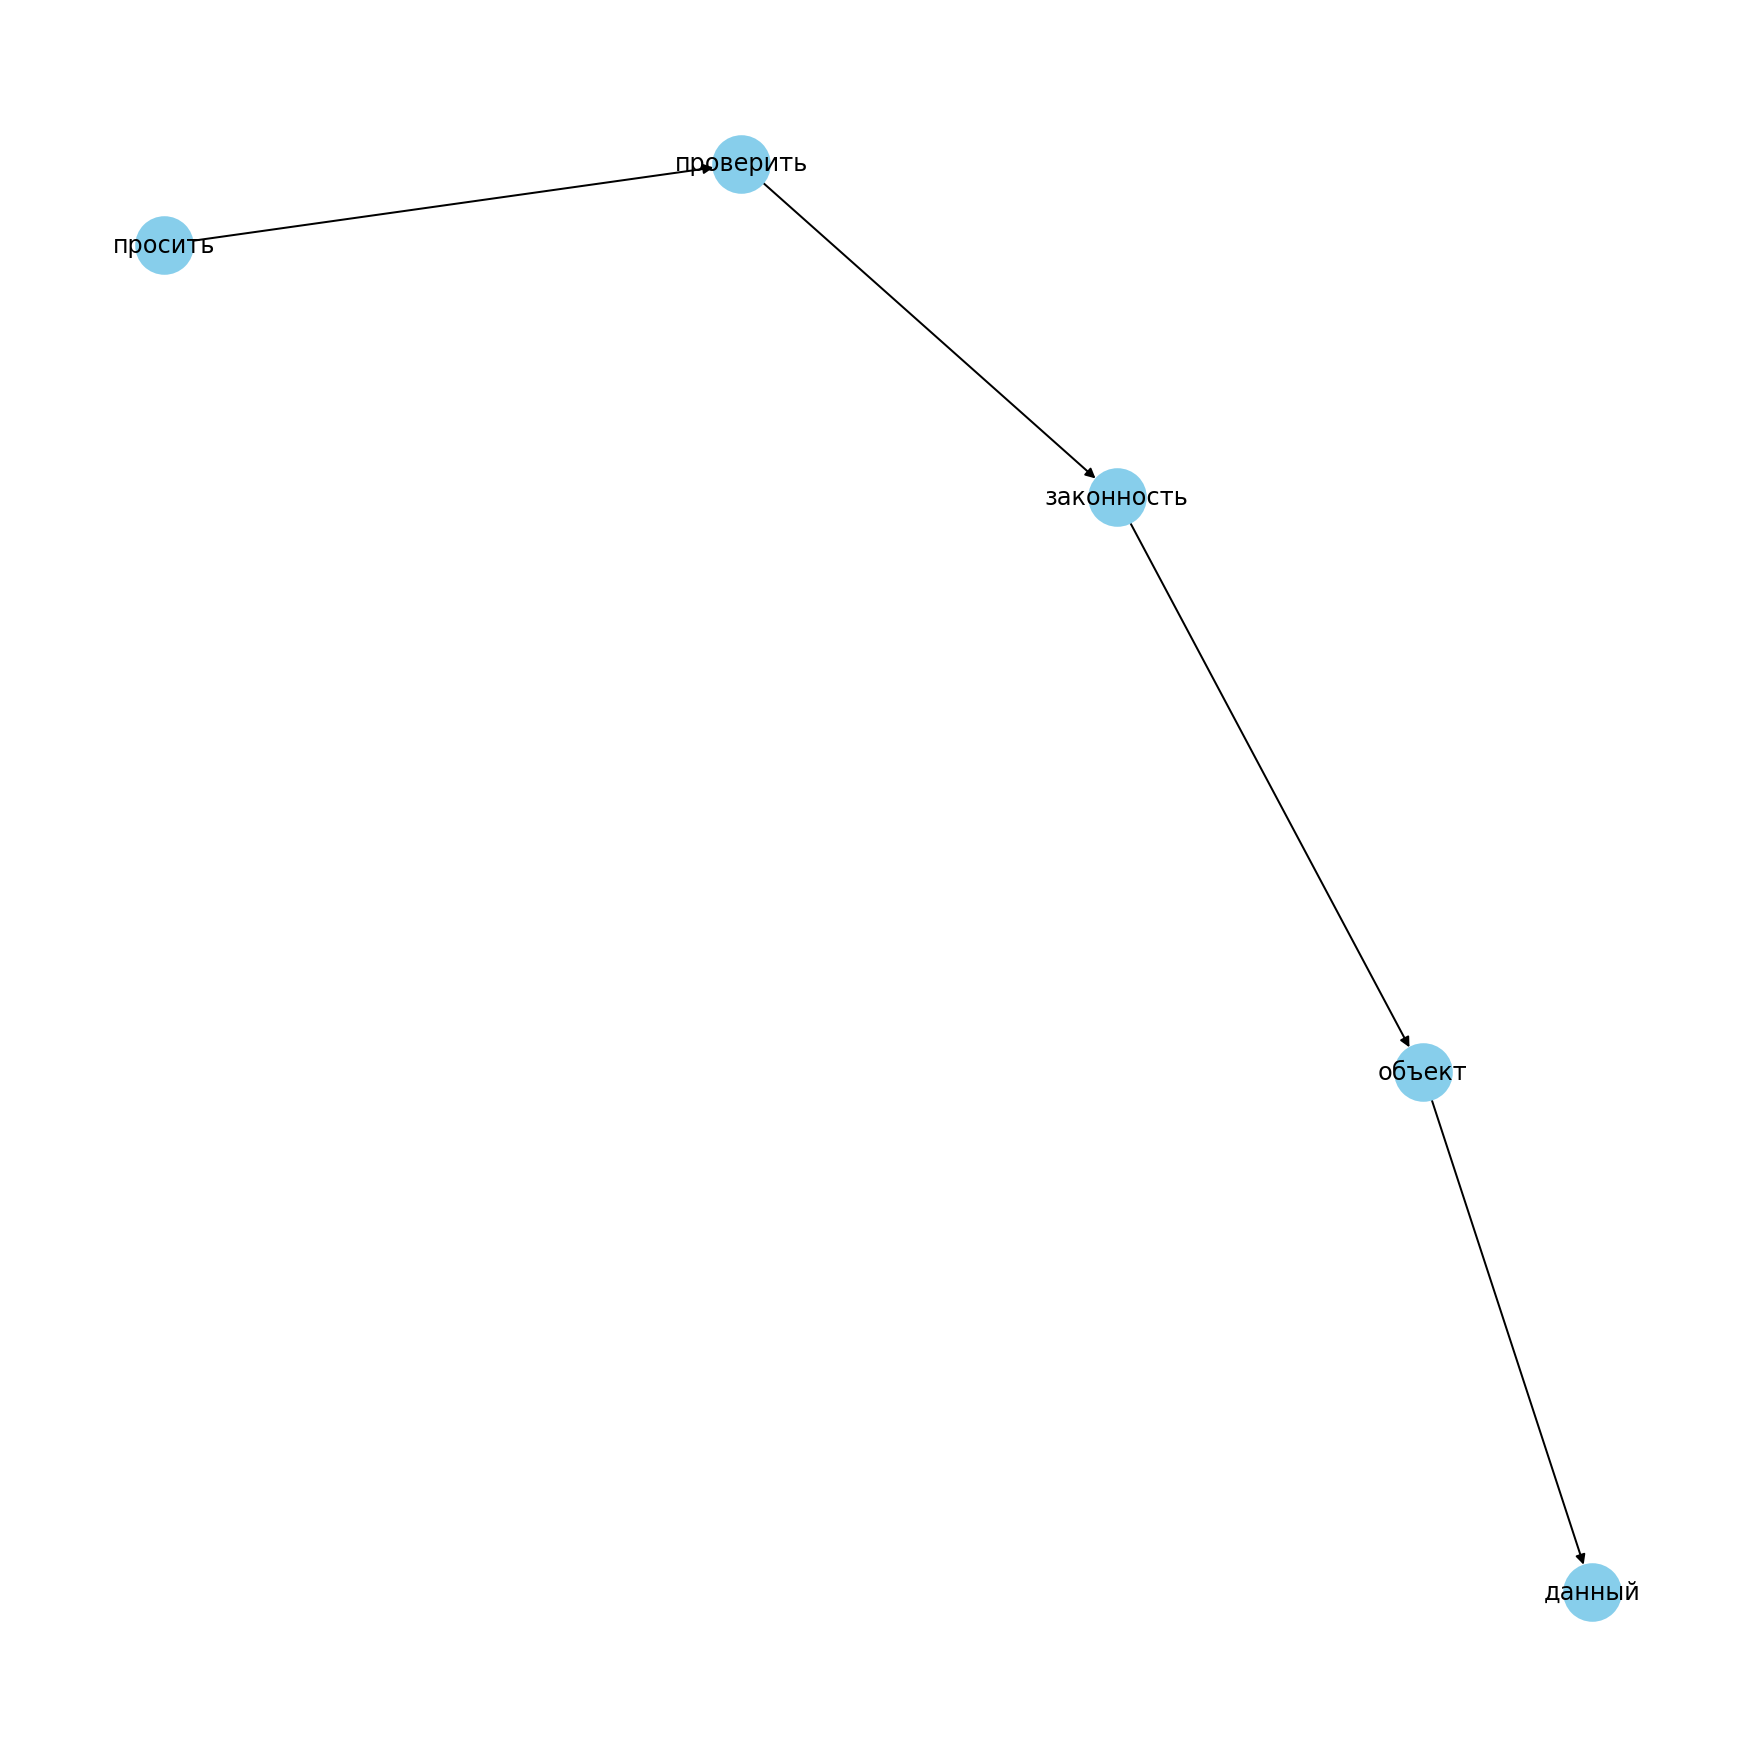

In [ ]:
G = nx.from_pandas_edgelist(res_df,'parent', 'child', create_using=nx.MultiDiGraph()) # edge_attr=True,
plot_graph(G)

Граф сильно зашумлен. Профильтруем его, оставив только слова со следующими POS-тэгами ADJ, ADV, NOUN, NUM, VERB, X

- ADJ примеры: другой, новый, самый, первый, сам, должен, российский, большой, нужный, последний.  
- ADP примеры: в, на, с, по, к, из, о, для, от, за
- ADV примеры: так, уже, еще, можно, более, как, очень, однако, где, сейчас
- AUX примеры: быть, бы 
- CCONJ примеры: и, а, но, или, ни, да, либо, причем, зато, только 
- DET примеры: этот, свой, весь, тот, такой, наш, его, их, каждый, какой 
- INTJ примеры: ах, о, ох, а, эх, та-да-дам, ой, ай, алло, ба 
- NOUN примеры: год, человек, время, страна, дело, работа, система, жизнь, власть, вопрос 
- NUM примеры: один, два, много, несколько, три, 1, 10, 20, 2, пять 
- PART примеры: не, и, же, только, даже, вот, ли, лишь, именно, просто 
- PRON примеры: он, это, который, они, то, я, мы, она, что, все 
- PROPN примеры: Россия, Москва, США, Путин, Владимир, СССР, Европа, Сергей, Александр, Земля 
- PUNCT примеры: ,, ., “, -, :, ), (, ?, !, …
- SCONJ примеры: что, как, если, чтобы, когда, то, чем, хотя, поскольку, пока 
- SYM примеры: %, $, №, °, €, +, =, №№, ?
- VERB примеры: мочь, быть, стать, говорить, делать, сказать, иметь, считать, идти, получить
- X примеры: of, and, the, in, for, de, mignews.com, capture, di, money

[Документация](https://universaldependencies.org/treebanks/ru_syntagrus/index.html)

Прошу проверить законность данного объекта.


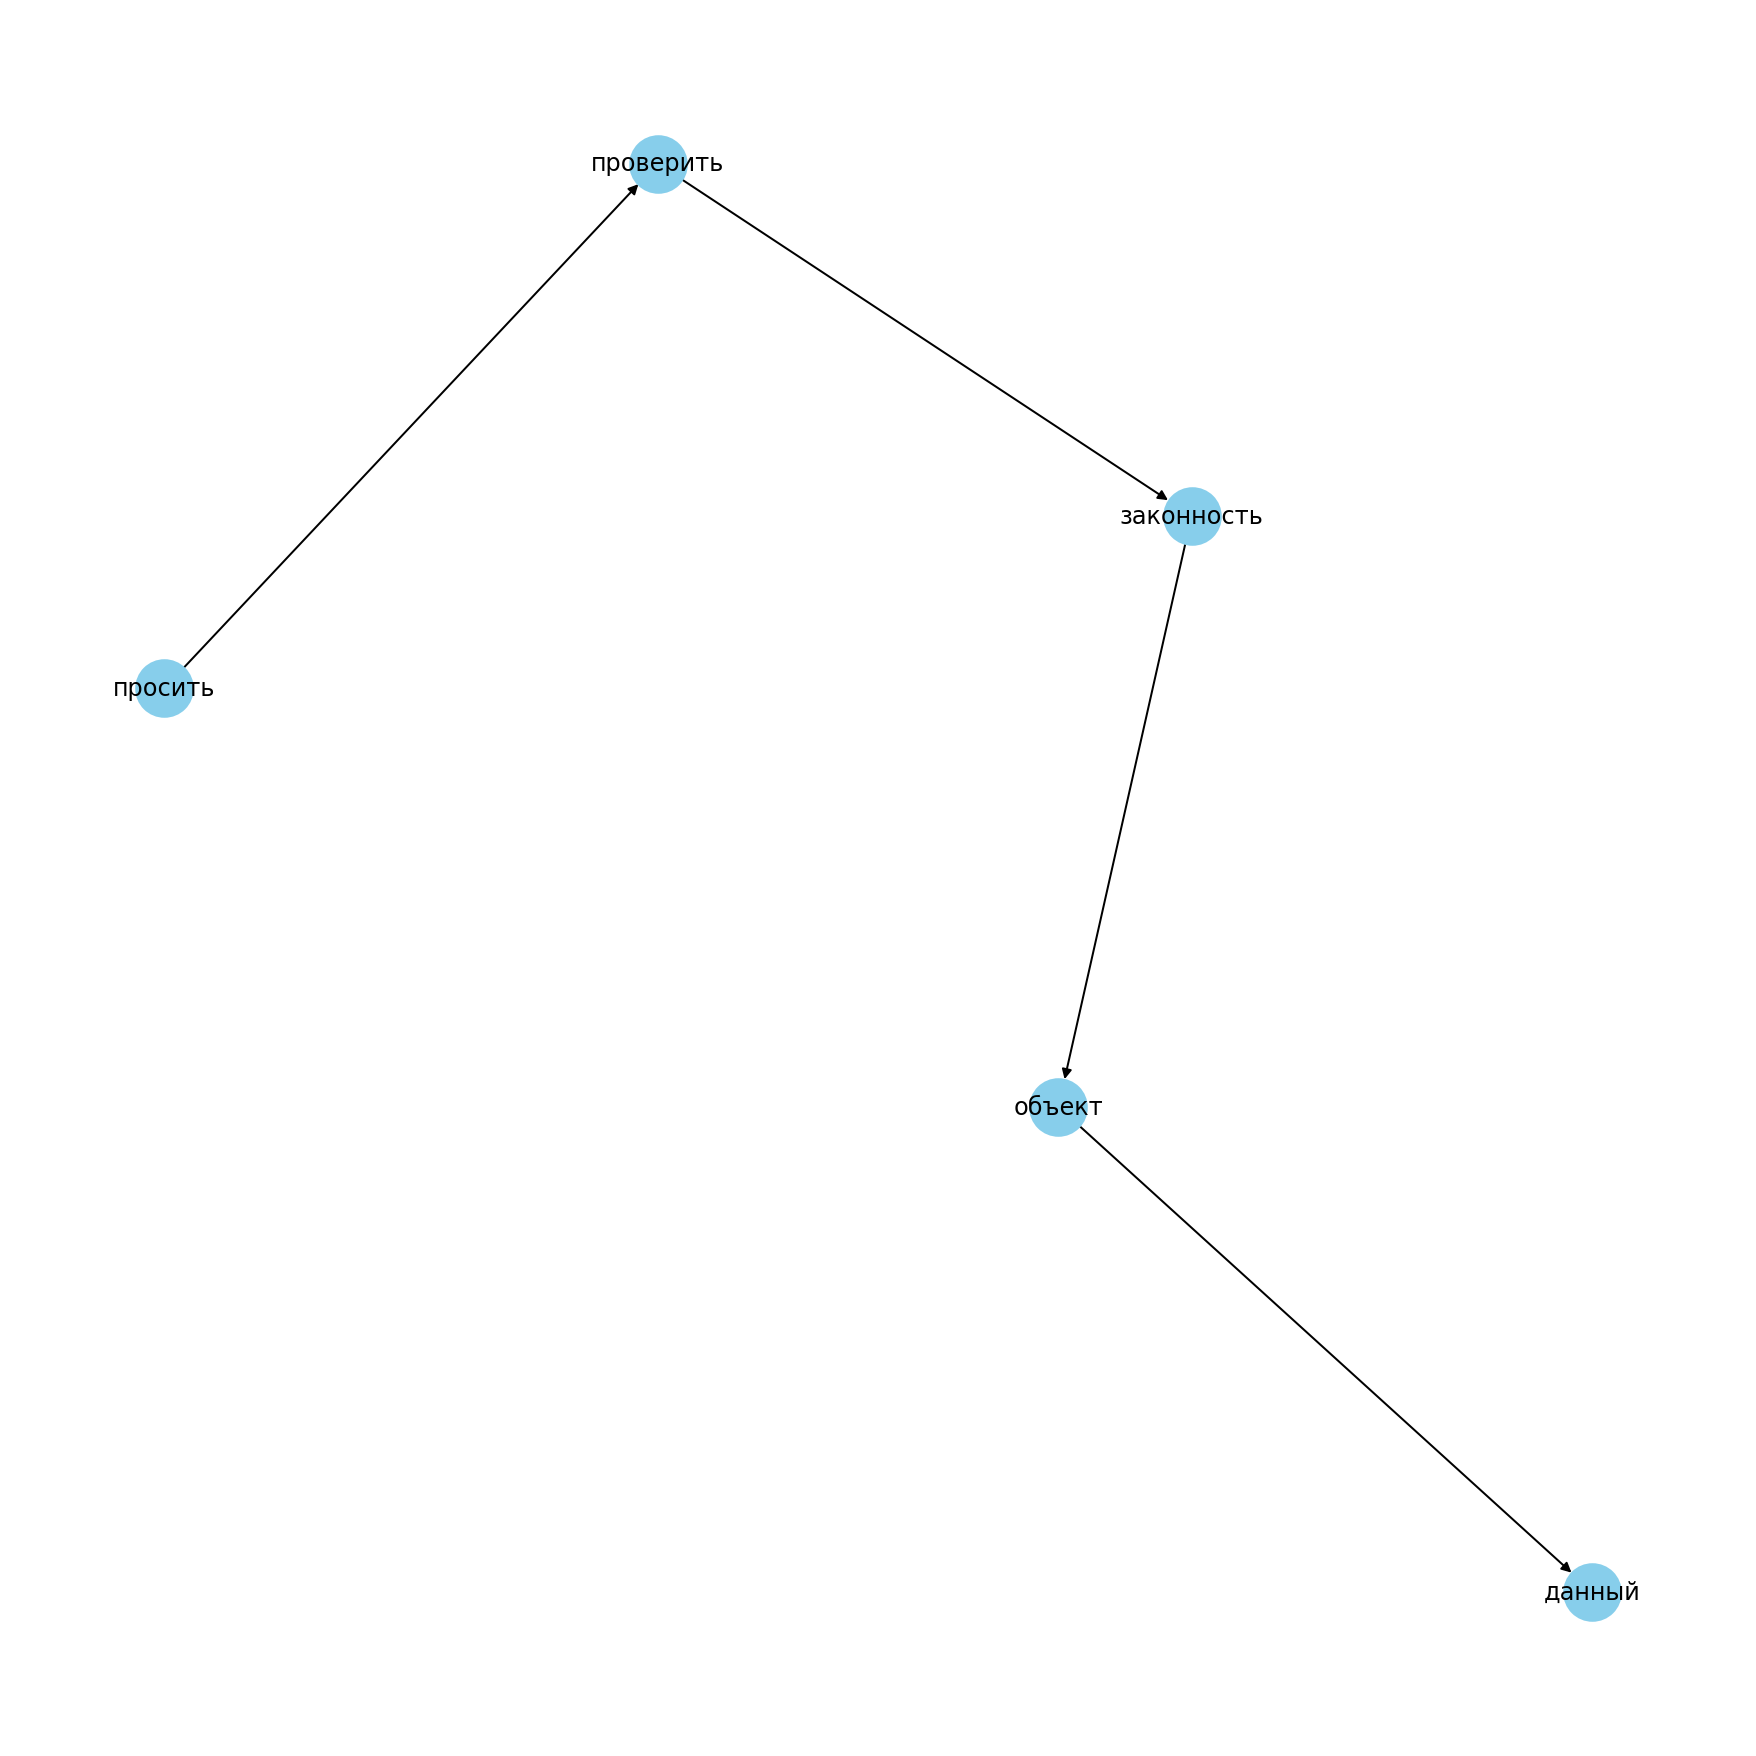

In [ ]:
print(test_string)
remove_upos = ['ADP','AUX','CCONJ','DET','INTJ','PART','PRON', 'PROPN','SCONJ','SYM'] 
drop_df, filtered_df = filter_df(res_df, remove_upos) # датафреймы: из удаленных upos и оставшихся
G = nx.from_pandas_edgelist(filtered_df,'parent', 'child', create_using=nx.MultiDiGraph()) 
plot_graph(G)

Построим граф только для одного узла и ограничим глубину двумя ветвями

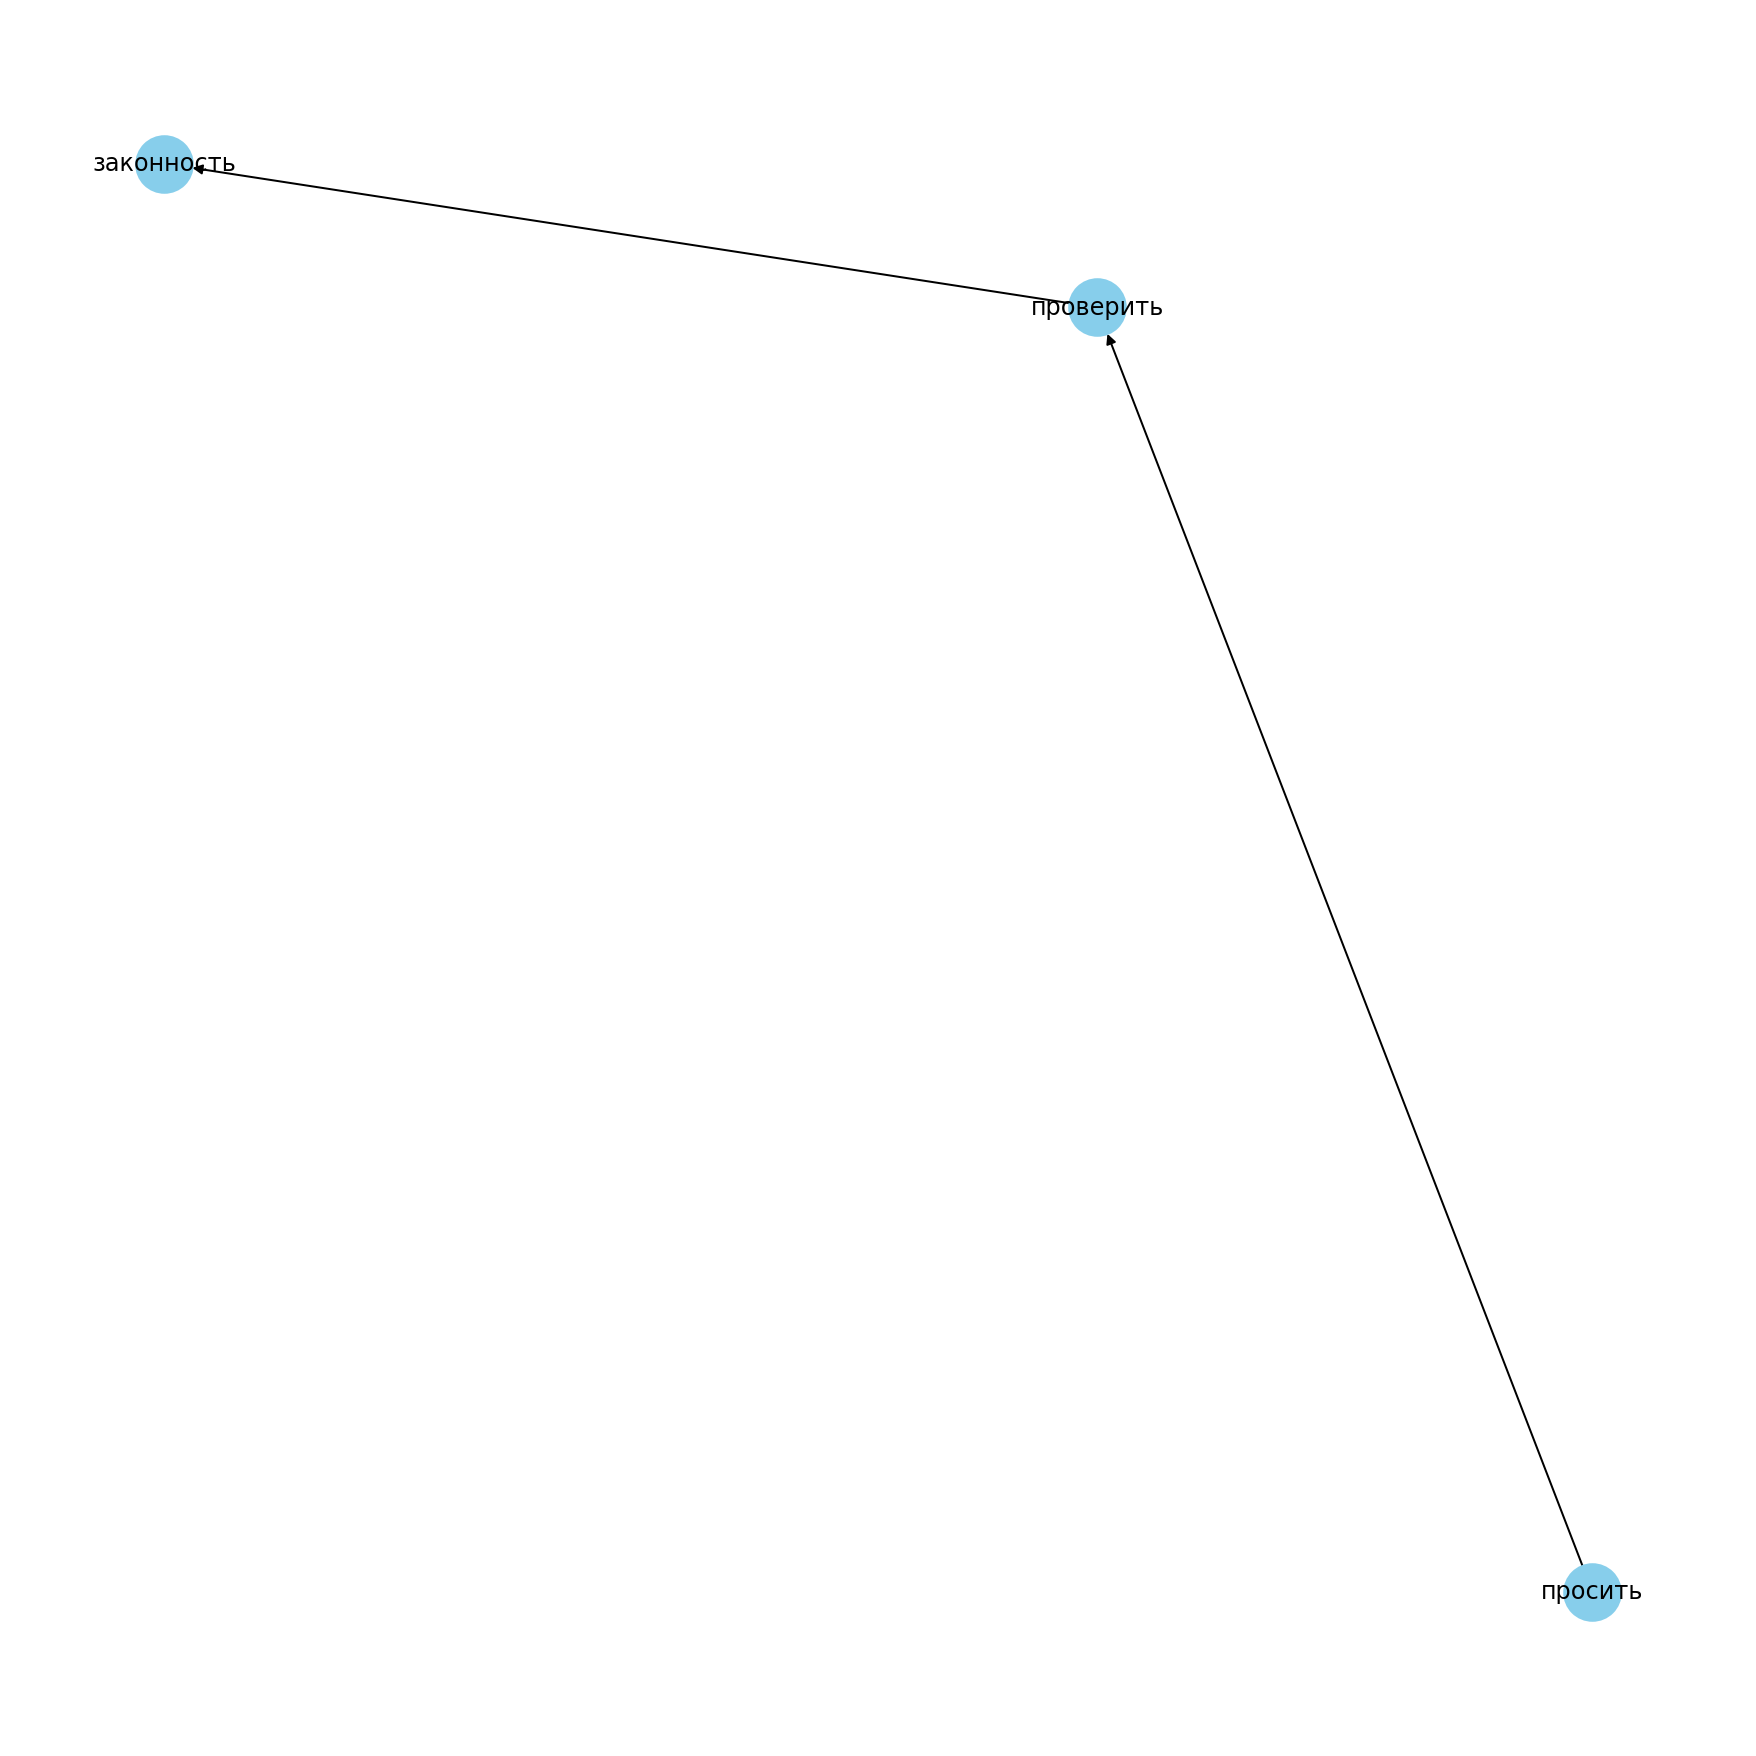

In [ ]:
test_node = filtered_df.iloc[0,0]
nx_G_d1 = nx.dfs_tree(G,test_node, depth_limit=2)
plot_graph(nx_G_d1)

## Работа с полным датасетом

Применим функцию ко всему датасету. Для удобства разобьем на блоки по 5000 предложений (расчет блока занимает ~40 минут, а суммарно ~12 часов). Промежуточные результаты сохраняются и затем объединяются. Для ускорения загрузим готовый результат (при желании, строки следующей ячейки можно раскомментировать и протестировать вручную).

In [ ]:
# from tqdm import tqdm
# tqdm.pandas()
# path_start = '/content/knowledge_'
# path_end = '.pkl'

# for part in range(19):
#     start = (part)*5000
#     end = start + 5000
#     sample = df_full.Street[start:end]
#     sample_knowledge = sample.progress_map(lambda x: get_knowledge(x))
#     filename = path_start + str(part) + path_end
#     sample_knowledge.to_pickle(filename)
#     print(filename, start,end)

# kg_series = pd.Series()
# for part in range(19):
#     filename = path_start + str(part) + path_end
#     batch = pd.read_pickle(filename)
#     kg_series = kg_series.append(batch)
    
# kg_series.to_pickle('/content/kg_series.pkl')
# kg_series

In [ ]:
!gdown --id "1HSfhEEBIJ6DLuwyCo3QqsFlYb6XKhEIc"
kg_series = pd.read_pickle('/content/kg_series.pkl')

Downloading...
From: https://drive.google.com/uc?id=1HSfhEEBIJ6DLuwyCo3QqsFlYb6XKhEIc
To: /content/kg_series.pkl
27.7MB [00:00, 105MB/s] 


In [ ]:
knowledge_list = []
for element in kg_series:
    knowledge_list += element

kg_df = pd.DataFrame(knowledge_list, columns = ['parent','parent_upos','child', 'child_upos'])
print('Число пар "Родительское_слово+Дочернее_слово":',kg_df.shape[0])
kg_drop_df, kg_df = filter_df(kg_df, remove_upos)
print('Число пар после фильтрации:',kg_df.shape[0])

Число пар "Родительское_слово+Дочернее_слово": 931138
Число пар после фильтрации: 691372


In [ ]:
kg_df = kg_df.loc[:,['parent','child']]
topk = kg_df.groupby(['parent','child']).size().sort_values(ascending=False).reset_index()
print('Число уникальных пар',topk.shape[0])
print('\nСамые популярные пары:')
print(topk.head())

Число уникальных пар 214062

Самые популярные пары:
        parent       child     0
0  конструкция   рекламный  9598
1    проверить  законность  5257
2      просить   проверить  4986
3   законность  размещение  3119
4      принять        мера  2626


Посмотрим в качестве примера на родительское слово *__просить__*

In [ ]:
parent_name = 'просить'
parent_test = topk.loc[topk['parent'] == parent_name]
print('Дочерних слов:',parent_test.shape[0])
print(parent_test[:5])

Дочерних слов: 966
     parent          child     0
2   просить      проверить  4986
8   просить  демонтировать  1981
15  просить         убрать  1606
22  просить        принять  1228
44  просить      устранить   808


Для слова *__просить__* существует 966 дочерних слов. То есть на графе из него будет выходить 966 стрелок.  
Добавим фильтр, который будет оставлять определенное количество самых часто встречающихся дочерних слов (rays). Дополнительно добавим возможность выбирать глубину графа (levels). Можно ввести любое Родительское слово, менять количество дочерних слов и глубину  
__В конце раздела будет интерактивный граф__.

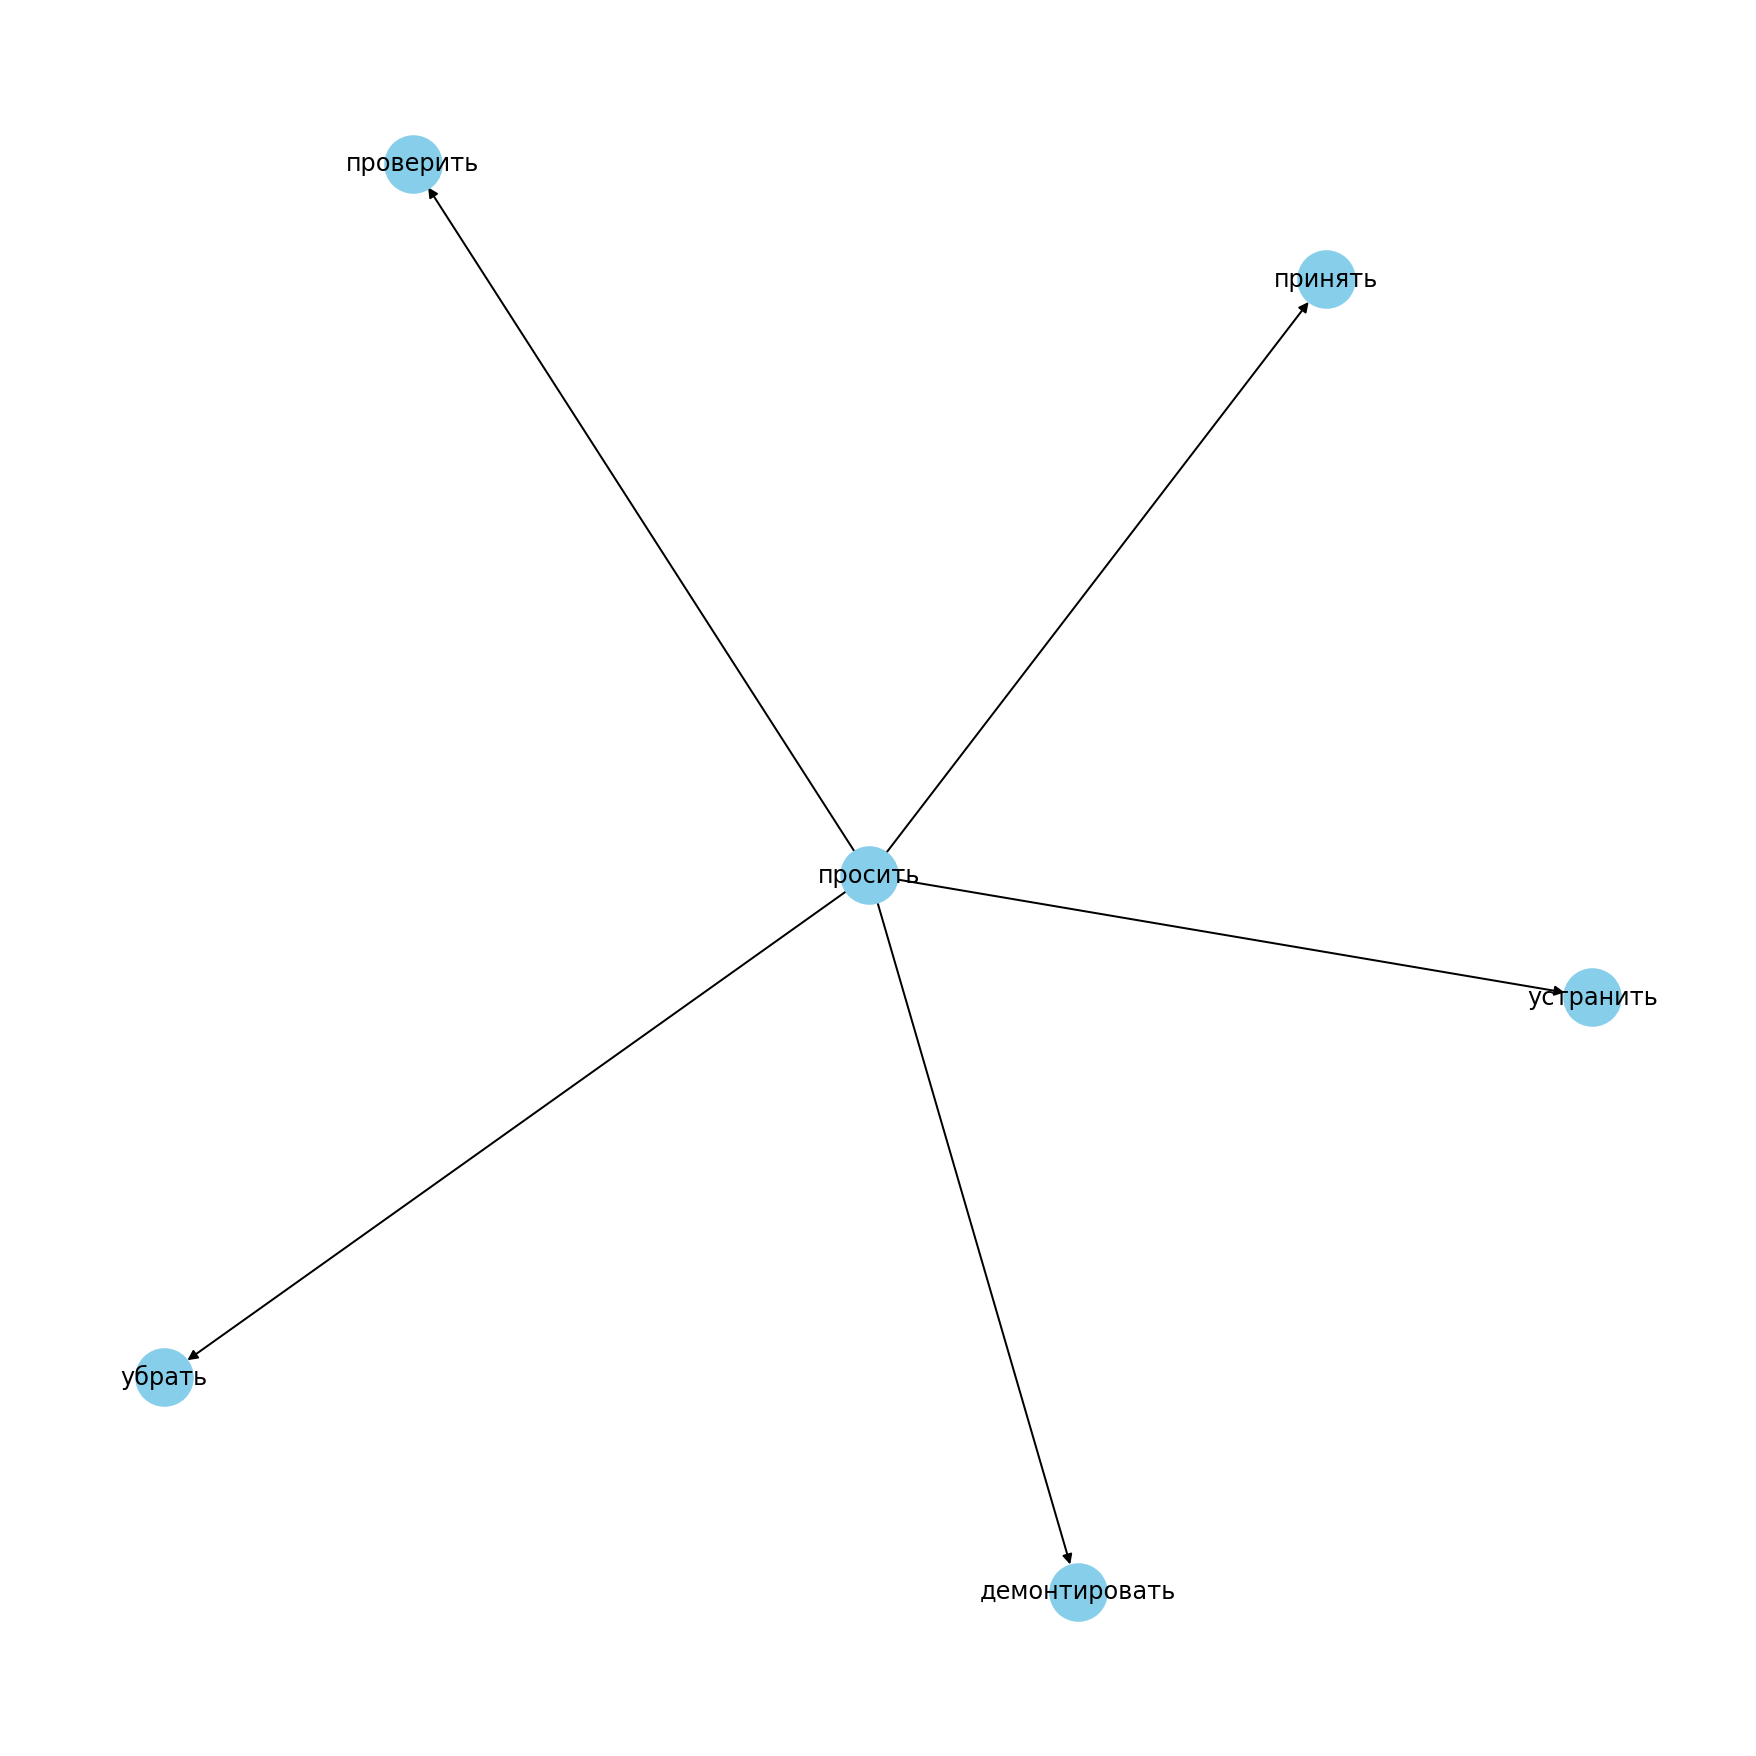

In [ ]:
def knowledge_limit(df, parent_name, levels,rays):
    parent_name = [parent_name]
    new_df = pd.DataFrame()
    for level in range(levels+1):
        new_parent_name = []
        for parent in parent_name:
            limit_df = df.loc[df['parent'] == parent].iloc[:rays,:]
            new_df = new_df.append(limit_df)
            new_parent_name += list(limit_df.child)
        parent_name = new_parent_name

    return new_df

parent_name = 'просить'
levels = 1
rays = 5

kg_df_limit = knowledge_limit(topk,parent_name, levels, rays)
G = nx.from_pandas_edgelist(kg_df_limit,'parent', 'child', create_using=nx.MultiDiGraph()) 
nx_G_d1 = nx.dfs_tree(G,source=parent_name, depth_limit=levels) #topk[:1].index[0]
plot_graph(nx_G_d1)

Составим список Топ50 Родительских слов (для интерактивного графа)

In [ ]:
top50_nodes = list(kg_df.groupby('parent').size().sort_values(ascending=False).index)[:50]
print(top50_nodes)

['конструкция', 'просить', 'проверить', 'размещение', 'установить', 'убрать', 'разместить', 'территория', 'мусор', 'просьба', 'дом', 'реклама', 'находиться', 'демонтировать', 'законность', 'установка', 'отсутствовать', 'стоить', 'работа', 'щит', 'место', 'нет', 'вести', 'устранить', 'восстановить', 'часть', 'принять', 'убирать', 'лежать', 'день', 'торговля', 'делать', 'площадка', 'должен', 'плитка', 'состояние', 'объект', 'остаться', 'привести', 'сторона', 'улица', 'нарушение', 'мочь', 'захламление', 'адрес', 'захламить', 'расположенный', 'валяться', 'куча', 'время']


Результат - интерактивный граф для топ50 Родительских слов, можно менять параметры графа и он автоматически перестраивается (перезапускать ячейку не нужно)

просить


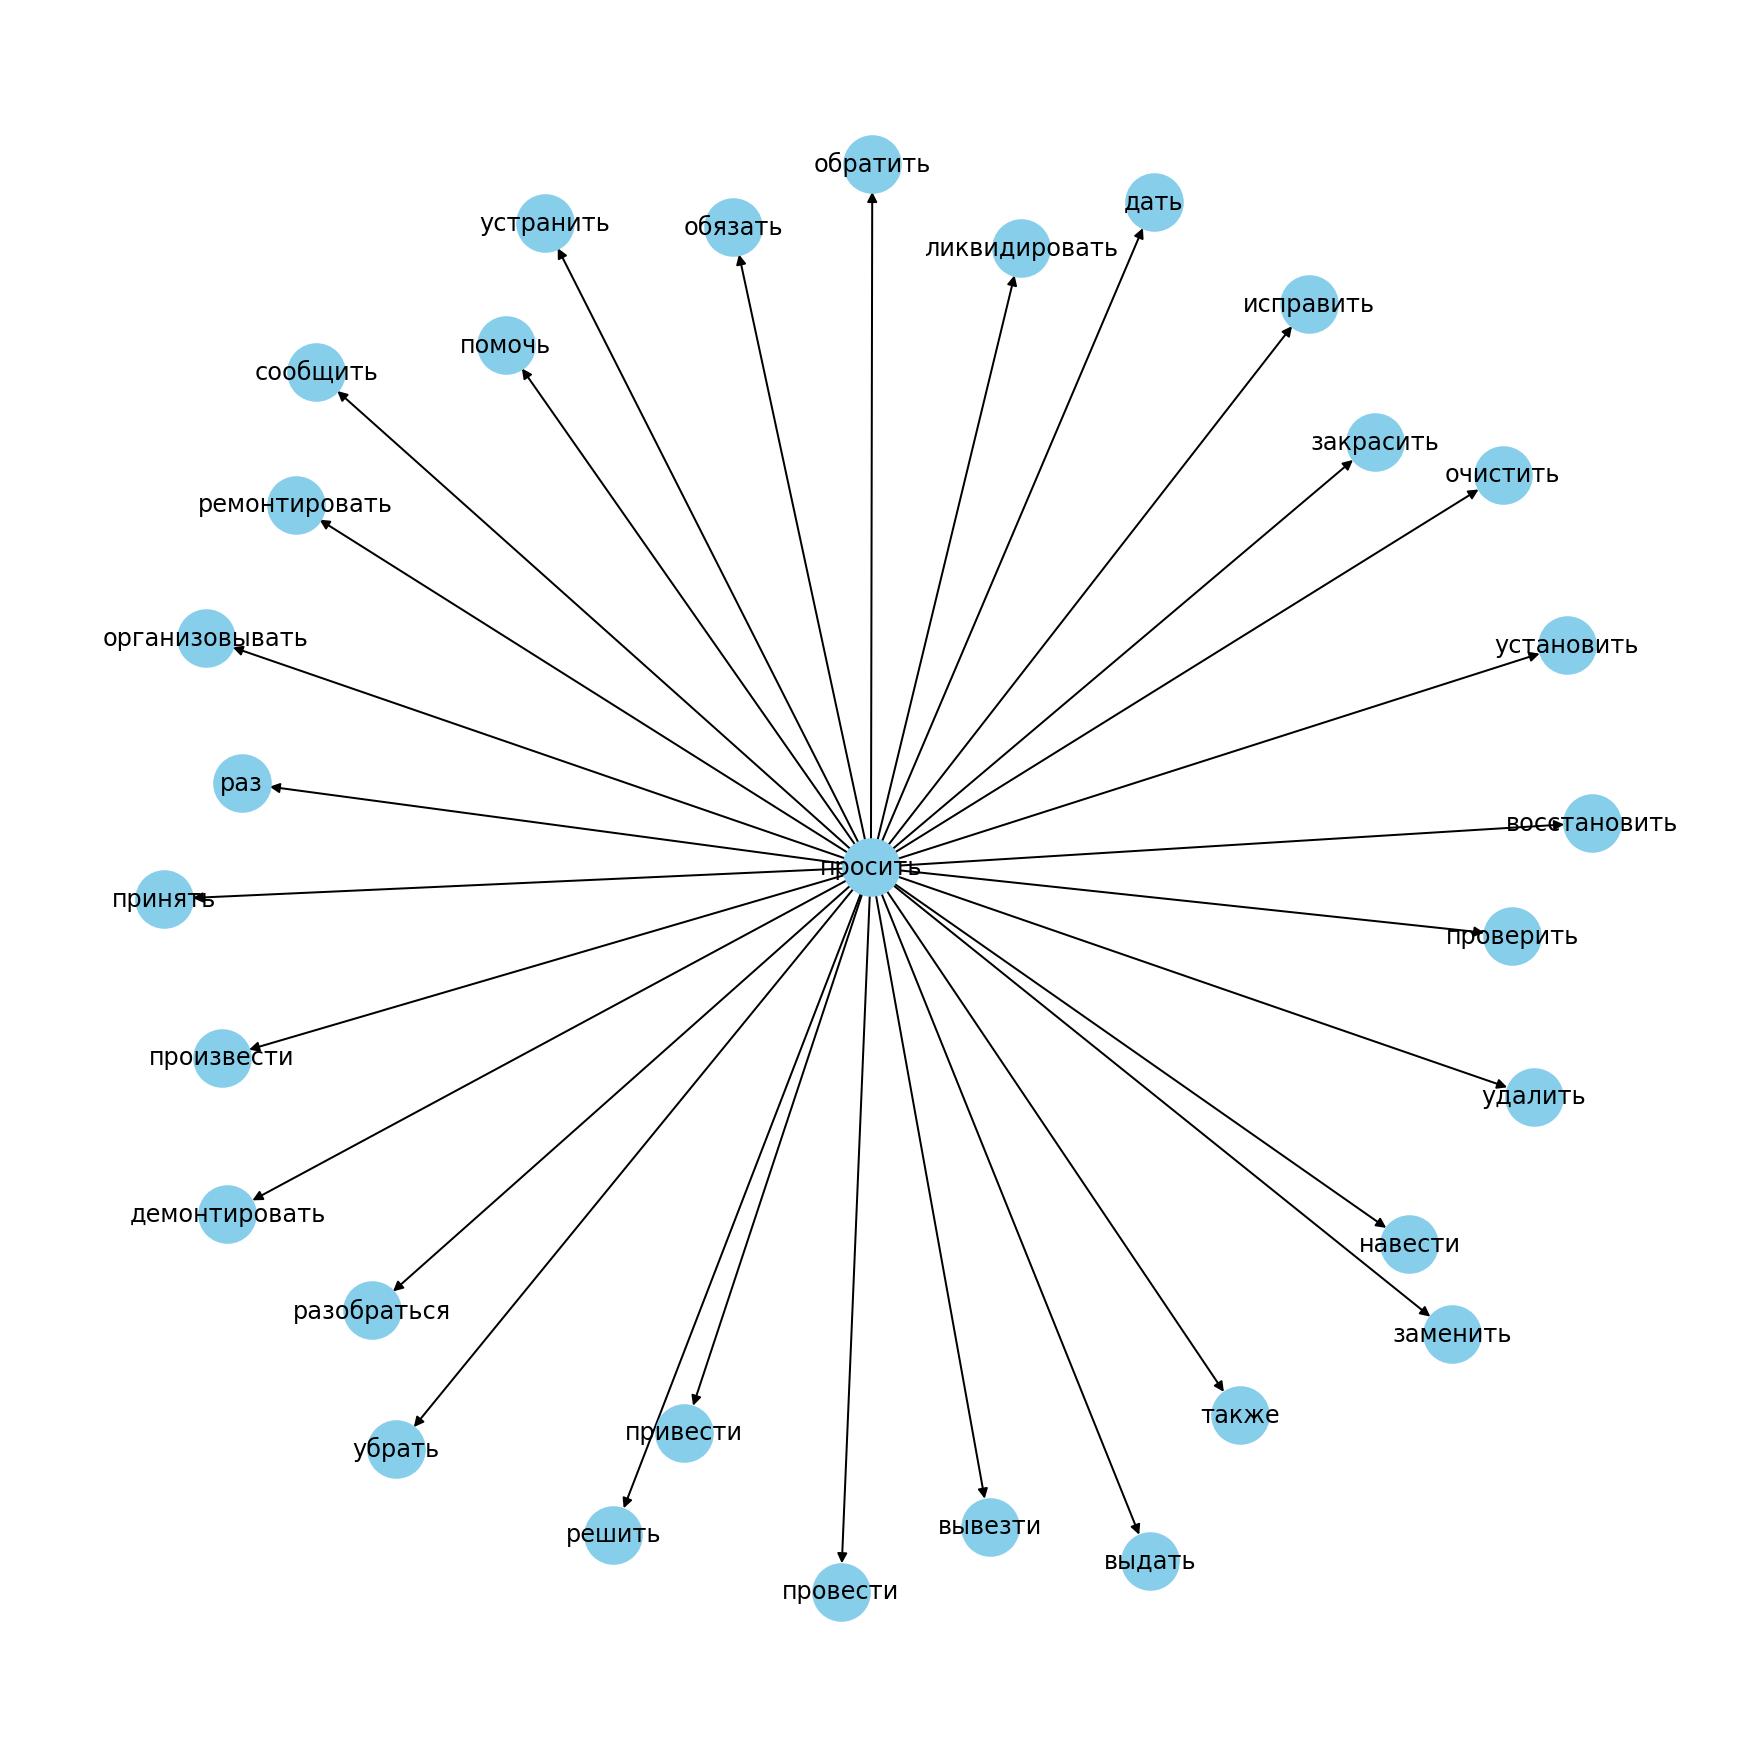

In [ ]:
#@title Интерактивный граф { run: "auto", form-width: "50%", display-mode: "form" }
one_of_top50_nodes = '\u043F\u0440\u043E\u0441\u0438\u0442\u044C' #@param ['конструкция', 'просить', 'проверить', 'размещение', 'установить', 'убрать', 'разместить', 'территория', 'мусор', 'просьба', 'дом', 'реклама', 'находиться', 'демонтировать', 'законность', 'установка', 'отсутствовать', 'стоить', 'работа', 'щит', 'место', 'нет', 'вести', 'устранить', 'восстановить', 'часть', 'принять', 'убирать', 'лежать', 'день', 'торговля', 'делать', 'площадка', 'должен', 'плитка', 'состояние', 'объект', 'остаться', 'привести', 'сторона', 'улица', 'нарушение', 'мочь', 'захламление', 'адрес', 'захламить', 'расположенный', 'валяться', 'куча', 'время']
levels = 1 #@param {type:"slider", min:1, max:5, step:1}
rays = 30 #@param {type:"slider", min:1, max:50, step:1}
print(one_of_top50_nodes)
kg_df_limit = knowledge_limit(topk,one_of_top50_nodes, levels, rays)
G = nx.from_pandas_edgelist(kg_df_limit,'parent', 'child', create_using=nx.MultiDiGraph()) 
nx_G_d1 = nx.dfs_tree(G,source=one_of_top50_nodes, depth_limit=levels) #topk[:1].index[0]
plot_graph(nx_G_d1)

# 4. Выводы:
- Проведен анализ данных, построены распределения жалоб по тематикам, районам, адресатам, временам года.
- Построен интерактивный граф распределения количества жалоб по районам.
- Построен граф знаний


Пути улучшения - использовать нейронную сеть для упрощения текстов. Я тестировал решение, основанное на mBART из соревнования [RuSimpleSentEval (RSSE)](https://competitions.codalab.org/competitions/29037#learn_the_details). Можно посмотреть в [Google Colab](https://colab.research.google.com/drive/1izjYmxWYO6mTWt5XEQ06dV32yMjfKsML?usp=sharing#forceEdit=true&sandboxMode=true). Оно давало очень хороший результат, но медленно работало (2 часа на 1000 строк, суммарно получилось бы 180 часов). В итоге пришлось от него отказаться.

